  # ASETS-II cases simulation

  This is an example of a simulation package for conjugate heat transfer of an
  oscillating heat pipe. SI units are used and units are emitted

  ### What do we need to solve an OHP problem?

  **specify properties** : Solid property, Fluid property

  **set the geometries** : Computational domain, Heaters/Condensers, OHP shapes

  **construct the systems** : Fluid system(1D), HeatConduction system(2D)

  **initialize** : initialize the integrators and the data structs for saving

  **solve** : time marching to solve the two weakly coupled integrators
  alternately

  **save/examine** : save the data for post-processing

  # Packages

  Firstly, let's import the necessary packages, you may need to install them
  for the first time.

  if you are first time user, you can install the OscillatingHeatPipe package by creating a new cell and running:

] add https://github.com/liyuxuan48/ComputationalHeatTransfer.jl.git
] add Plots
] add ProgressMeter

you only need to run the above cell once and then just delete them:)

In [1]:
using Revise

In [2]:
using OscillatingHeatPipe # our main package
using Plots # for plotting
using ProgressMeter # to have a progress bar in the calculation

[ Info: Precompiling OscillatingHeatPipe [d0e5c285-36a4-4c17-b2d2-a3652d369245] (cache misses: include_dependency fsize change (2), mismatched flags (4))


  # Specify properties

  ### Solid Physical parameters

  params is the HeatConductionParameters for the plate material. The numbers
  below represents aluminum.

In [3]:
ρₛ = 2730; # material density [kg/m^3]
cₛ  = 8.93e02; # material specific heat [J/kg K]
kₛ  = 1.93e02; # material heat conductivity
αₛ = kₛ/ρₛ/cₛ

dₛ = 1.5e-3; # effective d (The thickness of an ideal uniform thickness plate occupying the same volume)

  ### Fluid Physical parameters

  pfluid contains the vapor and liquid properties at a constant reference
  temperature. Noted that the vapor pressure and the vapor density will be
  functions of temperatures during the simulation, other properties are
  extracted from pfluid as an approximate value.

In [4]:
Tref = 291.2 # reference temperature
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref) # This function relies on CoolProp.jl package

Saturation properties for Butane at constant temperature 291.2 [K]


  # Set the geometries

  ### Construct the domain "g"

  The 2D domain has a rectangular shape. The actual plate can be of arbitrary shape. In this section we only construct the domain, and then construct the plate (slightly smaller than the domain)

In [ ]:
Δx = 0.0007 # [m] # grid size, at the same order of 1D OHP channel node spacing ~ 0.001[m]

Lx = 6*INCHES*1.02; # plate size x [m]
Ly = 2*INCHES*1.05; # plate size y [m]
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits

g = PhysicalGrid(1.03 .* xlim,1.1 .* ylim,Δx); # build a gird slightly larger than the plate

### Boundary conditions

In this section, you can design your plate's shape, here we still construct a rectangular plate, but it can has arbitrary shape. You only need to supply a vector of x coordinates of the nodes and a vector of y coordinates and supply it to the Polygon function

In [6]:
Δs = 1.4*cellsize(g) # 1D OHP node spacing, here it is 1.4Δx

xbound = [ -Lx/2,-Lx/2, 
            Lx/2, Lx/2]; # x coordinates of the shape

ybound = [  Ly/2,-Ly/2, 
           -Ly/2, Ly/2]; # y coordinates of the shape

body = Polygon(xbound,ybound,Δs)

Closed polygon with 4 vertices and 426 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


The initial location is centered at (0,0), you can use MotionTransform to move it and rotate it if needed.

In [7]:
X = MotionTransform([0,0],0) # move the plate or rotate the plate
joint = Joint(X)
m = RigidBodyMotion(joint,body)
x = zero_motion_state(body,m)
update_body!(body,x,m)

Closed polygon with 4 vertices and 426 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


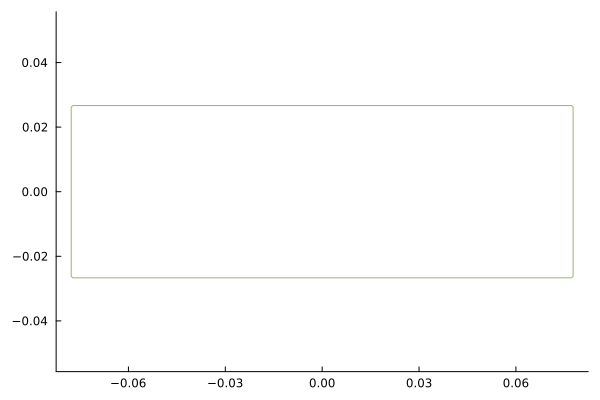

In [8]:
plot(body,fillalpha=0) # your plate (smaller than the domain g)

### Setting adiabatic bondary conditions for the plate boundary

No need to change this, unless you want a B.C. other than adiabatic on the edges!

In [9]:
function get_qbplus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbplus = zeros_surface(base_cache)
    return qbplus
end

function get_qbminus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbminus = zeros_surface(base_cache)
    # qbminus .= nrm.u
    return qbminus
end

bcdict = Dict("exterior" => get_qbplus,"interior" => get_qbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_qbminus
  "exterior" => get_qbplus

## Set physical parameters and evaporators and condensers

In [10]:
# These two values are only used for getting the heat flux in the heatermodel below, but it needs to be stored in phys_params first

power = 70 # [W], total power
areaheater_area = 50e-3 * 50e-3 # [m] total area

0.0025000000000000005

In [11]:
phys_params = Dict( "diffusivity"              => αₛ,
                    "flux_correction"          => ρₛ*cₛ*dₛ,
                    # "angular velocity"         => 0.0,
                    "Fourier"                  => 1.0,
                    "ohp_flux"                 => [NaN], # initial value, the value here is useless
                    "areaheater_power"         => power, # total power
                    "areaheater_area"          => areaheater_area, # total area
                    "areaheater_temp"          => 0.0,   # relative temperature compared with "background temperature"
                    "areaheater_coeff"         => 4000.0,
                    "background temperature"   => Tref
                     )
     

Dict{String, Any} with 9 entries:
  "areaheater_coeff"       => 4000.0
  "Fourier"                => 1.0
  "flux_correction"        => 3656.84
  "ohp_flux"               => [NaN]
  "diffusivity"            => 7.91668e-5
  "areaheater_area"        => 0.0025
  "areaheater_power"       => 70
  "areaheater_temp"        => 0.0
  "background temperature" => 291.2

  ### Set up the evaporators and condensers

heatermodel! and condensermodel! are used to determine the heat flux for 2D heat equation! (already scaled by plate thickness)

No need to modify, unless you don't want a heater depending on heat flux and a condenser depending on temperature difference and heat transfer coefficient.

In [12]:
function heatermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    σ .= phys_params["areaheater_power"] / phys_params["areaheater_area"] / phys_params["flux_correction"] 
end


function condensermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    T0 = phys_params["areaheater_temp"]
    h = phys_params["areaheater_coeff"]
    corr = phys_params["flux_correction"] 

    σ .= h*(T0 - T) / corr
end

condensermodel! (generic function with 1 method)

similar to constructing the plate, you need to construct a body(fregion1_h), move it(tr1_h), to construct a heater

In [13]:
fregion1_h = Rectangle(25e-3,25e-3,1.4*Δx)
# fregion2_h = deepcopy(fregion1_h)
tr1_h = RigidTransform((0.0,-0.0),0.0)
# tr2_h = RigidTransform((-25e-3,-0.0),0.0)

heater1 = AreaForcingModel(fregion1_h,tr1_h,heatermodel!);
# heater2 = AreaForcingModel(fregion2_h,tr2_h,heatermodel!);

same to the condenser

In [14]:
fregion1_c = Rectangle(15e-3,1.0INCHES,1.4*Δx)
# fregion2_c = deepcopy(fregion1_c)
tr1_c = RigidTransform((2.4INCHES,-0.0),0.0)
# tr2_c = RigidTransform((-2.5INCHES,-0.0),0.0)

cond1 = AreaForcingModel(fregion1_c,tr1_c,condensermodel!);
# cond2 = AreaForcingModel(fregion2_c,tr2_c,condensermodel!);

  ### Set up OHP channel's shape

  construct_ohp_curve is a built-in function that generates two arrays: x that
  contains all x values of the discrete points, and y contains all y values. x
  and y have the same length.

  You can also customize this function to generate an OHP shape of your choice
  as long as they produce x array and y array.

In [15]:
# xf and yf are useless here
# you can play with these parameters below to see how to design your ohp
    ds = 1.5Δx
    nturn = 13
    width_ohp = 46.25*1e-3
    length_ohp = 147.0*1e-3
    gap = 3e-3
    pitch = width_ohp/(2*nturn+1)
    x0, y0 = length_ohp/2 +2e-3, width_ohp/2

    x, y, xf, yf = construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2);

In [16]:
ohp = BasicBody(x,y) # build a BasicBody based on x,y
tr_ohp = RigidTransform((0.0,0.0),0.0)

function ohpmodel!(σ,T,t,fr::LineRegionCache,phys_params)
    σ .= phys_params["ohp_flux"] ./ phys_params["flux_correction"] 
end
ohp_linesource = LineForcingModel(ohp,tr_ohp,ohpmodel!);

  ### Plot what you got so far

  This is a exmaple of the compuational domain (the box) and the OHP channel
  serpentine (in blue)

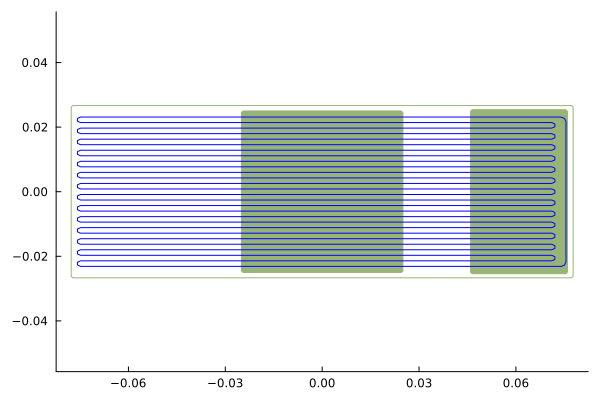

In [17]:
plot(body,fillalpha=0)
update_body!(fregion1_h,tr1_h)
update_body!(fregion1_c,tr1_c)
plot!(fregion1_h)
plot!(fregion1_c)

plot!(ohp,fillalpha=0,closedornot=true)

### remember to add your heater or condenser here if you have more than one, but always put the ohp_linesource at the end!

In [18]:
forcing_dict = Dict("heating models" => [heater1,cond1,ohp_linesource]) 
# forcing_dict = Dict("heating models" => [heater1,heater2,cond1,cond2,ohp_linesource])

Dict{String, Vector{AbstractForcingModel}} with 1 entry:
  "heating models" => [AreaForcingModel{Polygon{204, 4, ClosedBody}, MotionTran…

In [19]:
tspan = (0.0, 1.0); # start time and end time
dt_record = 0.2   # saving time interval

tstep = 4e-4     # actrual time marching step

0.0004

In [20]:
timestep_fixed(u,sys) = tstep

timestep_fixed (generic function with 1 method)

In [21]:
prob = NeumannHeatConductionProblem(g,body,scaling=GridScaling,
                                             phys_params=phys_params,
                                             bc=bcdict,
                                             motions=m,
                                             forcing=forcing_dict,
                                             # timestep_func=timestep_fourier
                                             timestep_func=timestep_fixed
    );

  # Construct the systems

  ### Create HeatConduction system

  The solid module dealing with the 2D conduction, evaporator, condenser, and
  the OHP line heat source is constructed here.

In [22]:
sys_plate = construct_system(prob);

  ### Create OHP inner channel system

  sys_tube: fluid module system

In [23]:
# if you have a very short OHP and a large slugnum(initial slug number), it may blow up and you can reduce it if it blows up, 
# g = [-9.8,0.0] is for 90 degrees inclination angle, g here means the component of gravity along the plate. 
# For example, if you want a gravity force pointing to the left direction at an inclination angle of 30 degrees, g=[-9.8,0.0] .* cos(π/6)
sys_tube = initialize_ohpsys(sys_plate,p_fluid,power, slugnum=30, g = [-9.8,0.0])

3995 point OHP system filled with Butane


  # Initialize

  ### set time step

  ### combine inner tube and plate together

In [28]:
tspan_init = (0.0,1e4) # for plate, should be a range larger than the TOTAL time you plan to simulate (including saving and re-run),
# if the range is smaller than the total time range, there will be errors in temperature interpolations

u_plate = init_sol(sys_plate)# initialize plate T field to uniform Tref
integrator_plate = init(u_plate,tspan_init,sys_plate,save_on=false) # construct integrator_plate

u_tube = newstate(sys_tube) # initialize OHP tube
integrator_tube = init(u_tube,tspan,sys_tube); # construct integrator_tube

In [54]:
sys_tube.tube.L

4.234366909750736

In [61]:
randomXp(10.0,0.1,true)

generation failed


([(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)  …  (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)], [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)  …  (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)], 0.475131139475461)

### initialize arrays for saving

In [29]:
SimuResult = SimulationResult(integrator_tube,integrator_plate);

  # Solve

In [186]:
# integrator_tube = SimuResult.integrator_tube_resume
# integrator_plate = SimuResult.integrator_plate_resume


  ### Run the simulation and store data

In [30]:
@showprogress for t in tspan[1]:tstep:tspan[2]

    timemarching!(integrator_tube,integrator_plate,tstep)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        store!(SimuResult,integrator_tube,integrator_plate)
    end

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


  # Store data

In [27]:
using JLD2

In [189]:
# save_path = "../numedata/Zach_100s_90D_detail.jld2"
# save(save_path,"SimulationResult",SimuResult)

### take a peek at the solution (more at the PostProcessing notebook)

[ Info: Saved animation to /Users/jeff/JuliaProjects/OscillatingHeatPipe/examples/tmp.gif


Plots.AnimatedGif("/Users/jeff/JuliaProjects/OscillatingHeatPipe/examples/tmp.gif")
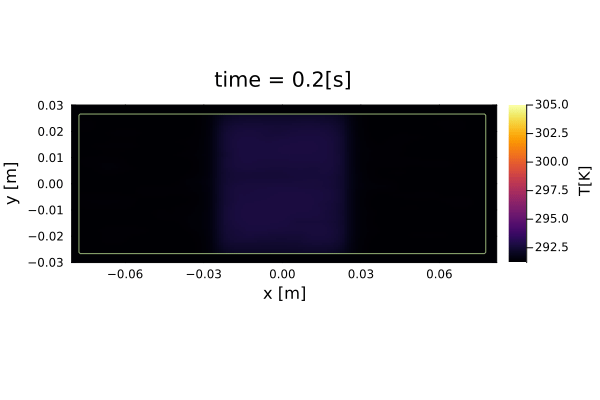

In [28]:
@gif for i in eachindex(SimuResult.tube_hist_t)
    # plot(OHPSlug(),i,SimuResult,aspectratio=1)
    plot(OHPTemp(),i,SimuResult,clim=(291.2,305.0))
    # plot(SimuResult.plate_T_hist[i],colorbar=true,fill=true)
    plot!(body,fillalpha=0)
end

[ Info: Saved animation to /Users/jeff/JuliaProjects/OscillatingHeatPipe/examples/tmp.gif


Plots.AnimatedGif("/Users/jeff/JuliaProjects/OscillatingHeatPipe/examples/tmp.gif")
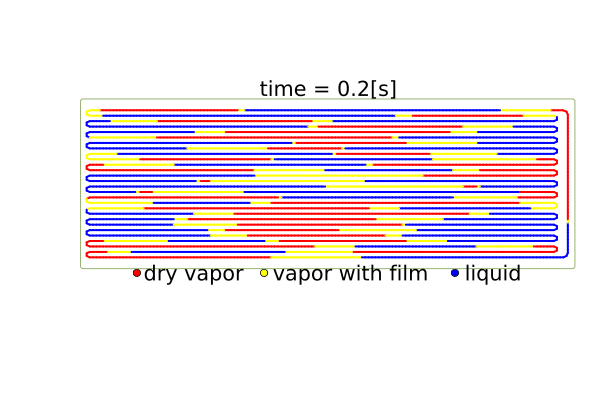

In [29]:
@gif for i in eachindex(SimuResult.tube_hist_t)
    plot(OHPSlug(),i,SimuResult,aspectratio=1)
    # plot(OHPTemp(),i,SimuResult,clim=(0.0,10.0))
    # plot(SimuResult.plate_T_hist[i],colorbar=true,fill=true)
    plot!(body,fillalpha=0)
end

### put some temperature sensors and see their temperature

In [30]:
x2Dsensors = [0.0,   0.0, 0.0, 0.0, 0.0,-3INCHES+12e-3,-3INCHES+35e-3,-3INCHES+65e-3,3INCHES-65e-3,3INCHES-35e-3,3INCHES-12e-3]
y2Dsensors = [-2e-2, -1e-2, 0.0, 1e-2, 2e-2,0.0,           0.0,            0.0,          0.0,          0.0,          0.0]
plate_sensors = (x2Dsensors,y2Dsensors);

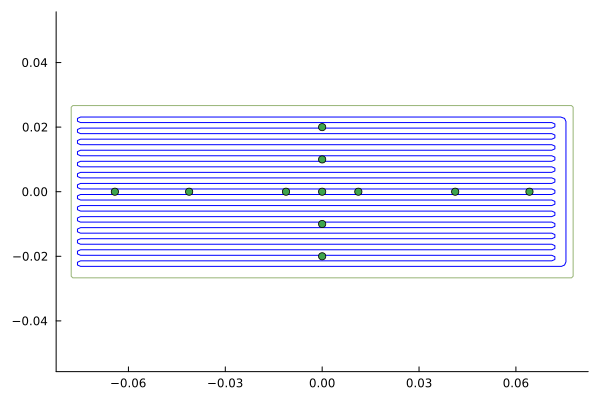

In [31]:
plot(body,fillalpha=0)
plot!(ohp,closedornot=true)
scatter!(plate_sensors)

In [32]:
t_hist,g_hist = getTcurve(plate_sensors,SimuResult);

In [33]:
RTD_for_plotting = [4,5];

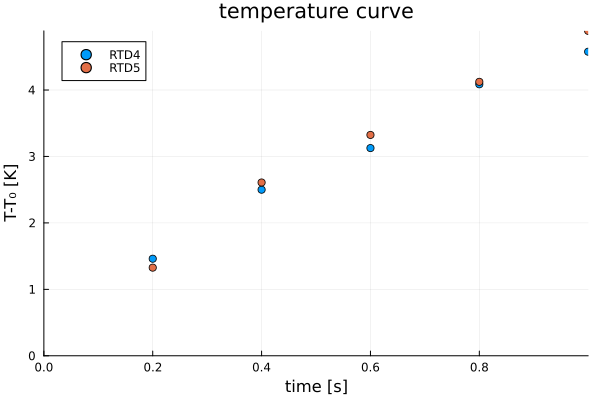

In [34]:
scatter(OHPTcurve(),RTD_for_plotting,(t_hist,g_hist),SimuResult)

In [197]:
# import XLSX
# expfile = expfileDict["O001_H001_P040"]
# exppath = "../expdata/"
# xf = XLSX.readxlsx(exppath*expfile);

In [198]:
# Onum, Hnum, power_exp = getconfig(expfile)
# RTDt,RTD = getRTD(xf,Onum);

In [199]:
# scatter(OHPTcurve(),RTD_for_plotting,(t_hist,g_hist),SimuResult)
# plot!(OHPTexp() ,RTD_for_plotting,(RTDt,RTD)     ,SimuResult,xlim=(100.9,101.0),ylim=(19,21))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*